In [1]:
import tensorflow as tf

print(tf.keras.__version__)

2.5.0


In [2]:
! git clone https://github.com/credo-ml/cnn-offline-trigger.git

Cloning into 'cnn-offline-trigger'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 24 (delta 8), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (24/24), done.


In [4]:
# ! unzip ./cnn-offline-trigger/data-set.zip

In [5]:
def loadData(path, verbose=True):

  import cv2
  import glob

  dots = []
  lines = []
  worms = []
  artefacts = []

  for img in glob.glob(path+"hits_votes_4_Dots/*.png"):
      n = cv2.imread(img)
      dots.append(n)
  target_dots = [0 for _ in dots]

  for img in glob.glob(path+"hits_votes_4_Lines/*.png"):
      n = cv2.imread(img)
      lines.append(n)
  target_lines = [1 for _ in lines]

  for img in glob.glob(path+"hits_votes_4_Worms/*.png"):
      n = cv2.imread(img)
      worms.append(n)
  target_worms = [2 for _ in worms]

  for img in glob.glob(path+"artefacts/*.png"):
      n = cv2.imread(img)
      artefacts.append(n)
  target_artefacts = [3 for _ in artefacts]

  images=dots+lines+worms+artefacts

  target_signals_binary = [0 for _ in (dots+lines+worms)]
  target_artefacts_binary = [1 for _ in artefacts]

  targets=target_signals_binary+target_artefacts_binary

  if verbose:
    print(len(images),len(targets))
    print(images[0].shape)
    print(len(dots), len(lines), len(worms), len(artefacts))


  return (images, targets)

In [6]:
# path="/content/drive/MyDrive/Colab Notebooks/hit-images/"
path = "hit-images-final/"

images, targets = loadData(path)

2354 2354
(60, 60, 3)
535 393 304 1122


In [7]:
def preprocessData(data, verbose=True):

  # import mahotas
  import numpy as np

  # print(wavelets)

  images, targets = data

  features = []
  bl_images = []
  th_images = []

  for img in images:

    img = img.astype('int32')

    blackwhite=img[:,:,0]+img[:,:,1]+img[:,:,2]
    # bl_images.append(blackwhite.copy())

    threshold = blackwhite.mean() + blackwhite.std() * 5
    threshold = threshold if threshold < 100 else 100 

    mask = np.where(blackwhite > threshold, 1, 0)
    blackwhite = blackwhite * mask
    
    # feature #1
    num_pixels_over_th = np.sum(mask)

    # feature #2
    total_luminosity_over_th = np.sum(blackwhite)

    out = (num_pixels_over_th,total_luminosity_over_th)
    features.append(out)

  feature_array, label_array = np.array(features), np.array(targets)

  if verbose:
    print(feature_array.shape)
    print(label_array.shape)

  return (feature_array, label_array)


In [8]:
feature_array, label_array = preprocessData(data=(images, targets))

(2354, 2)
(2354,)


In [9]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
import numpy as np

class BaseTrigger(BaseEstimator,ClassifierMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y):
#         compute minimal luminosity for artefacts and maximal luminosity for signals
#         compute minimal pix_count for artefacts and maximal pix_count for signals
        self.min_pixcount_arte_=X[:,0].max()
        self.min_lum_arte_=X[:,1].max()
        self.max_pixcount_sig_=X[:,0].min()
        self.max_lum_sig_=X[:,1].min()
        print("{} {} {} {}\n".format(self.min_pixcount_arte_,self.min_lum_arte_,self.max_pixcount_sig_,self.max_lum_sig_))
        for features,label in zip(X,y):
            pix_count=features[0,]
            lum=features[1,]
            if label==0 : #signal
                if pix_count>self.max_pixcount_sig_:
                    self.max_pixcount_sig_=pix_count
                if lum>self.max_lum_sig_:
                    self.max_lum_sig_=lum
            else:
                if pix_count<self.min_pixcount_arte_:
                    self.min_pixcount_arte_=pix_count
                if lum<self.min_lum_arte_:    
                    self.min_lum_arte_=lum
                    
        print("{} {} {} {}".format(self.min_pixcount_arte_,self.min_lum_arte_,self.max_pixcount_sig_,self.max_lum_sig_))    
        self.border_lum_=(self.min_lum_arte_+self.max_lum_sig_)/2
        self.border_pixcount_=(self.min_pixcount_arte_+self.max_pixcount_sig_)/2
        return self
    
    def predict(self, X):
        Y=np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            pix_count=X[i,0]
            # pix_count=0
            lum=X[i,1]
            if ((pix_count/self.border_pixcount_)**2+(lum/self.border_lum_)**2<=1):
                Y[i]=0
            else:    
                Y[i]=1
        return Y 
    
#     this method probably is not mandatory
#     def predict_proba(self, X):
#         pred = np.random.rand(X.shape[0], self.classes_.size)
#         return pred / np.sum(pred, axis=1)[:, np.newaxis]

In [10]:
input=zip(feature_array, label_array)

In [ ]:
# from sklearn.utils.estimator_checks import check_estimator
# check_estimator(BaseTrigger())

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature_array, label_array, test_size=0.33, random_state=1)

bt=BaseTrigger().fit(X_train,y_train)

# from sklearn.neighbors import KNeighborsClassifier
# bt = KNeighborsClassifier(n_neighbors=7)
# bt.fit(X_train,y_train)

# from sklearn.ensemble import RandomForestClassifier
# bt = RandomForestClassifier(max_depth=2, random_state=0)
# bt.fit(X_train,y_train)

3600 1814018 1 104

11 1488 174 60923


Confusion matrix, without normalization
[[402   9]
 [ 17 349]]
Normalized confusion matrix
[[0.97810219 0.02189781]
 [0.04644809 0.95355191]]


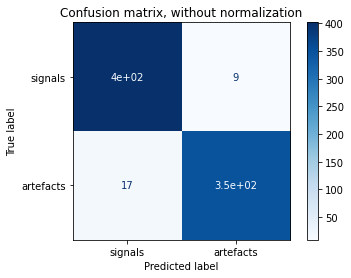

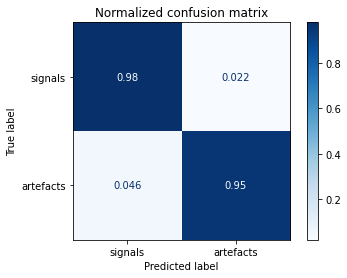

In [12]:
from sklearn.metrics import plot_confusion_matrix
from matplotlib import pyplot as plt
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(bt, X_test, y_test,
                                 display_labels=["signals","artefacts"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [13]:
m=0
idx=0
for i,(a,b) in enumerate(zip(feature_array,label_array)): 
    if b==0 and a[1]>m:
        m=a[1]
        idx=i
        
print("{} {}".format(m,idx))        
        

70170 1004


In [15]:
# import pickle
clf=bt
pkl_filename="baseline.pkl"
import os
from joblib import dump, load
dump(clf, pkl_filename) 

['baseline.pkl']

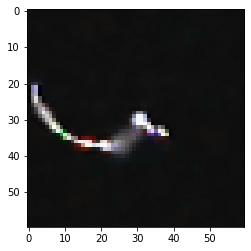

In [ ]:
from matplotlib import pyplot as plt
plt.figure()
plt.imshow(images[idx])

In [ ]:
def kf_validation(X_std, y, _clf_, rounds=1, verbose=False):
  import numpy as np
  from sklearn.model_selection import KFold
  from sklearn import svm
  from sklearn.metrics import accuracy_score
  from sklearn.metrics import confusion_matrix
  import matplotlib.pyplot as plt
  import tensorflow as tf
  from tensorflow import keras
  from tensorflow.keras.utils import to_categorical
  from functools import reduce

  scores = []
  CM = np.zeros_like(np.eye(4))
  cm_seq = []

  for _ in range(rounds):

    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(X_std)

    for train_index, test_index in kf.split(X_std):
      # print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = X_std[train_index], X_std[test_index]
      y_train, y_test = y[train_index], y[test_index]

      # C = 1.0
      clf = _clf_
      # clf = keras.models.load_model(_clf_)

      # keras.backend.clear_session()
      # clf.fit(X_train, to_categorical(y_train), batch_size=64, epochs=50, verbose=False)
      clf.fit(X_train, y_train)

      # cnn_model = build_cnn_model("relu", input_shape, verbose=False)
      # clf, cnn_history = compile_and_fit_model(cnn_model, X_train, to_categorical(y_train), 
      #                                          X_test, to_categorical(y_test), 
      #                                          64, 50, 
      #                                          verbose=False)

      # clf.load_weights('best_model.h5')

      # y_pred = np.argmax(clf.predict(X_test), axis=1)
      y_pred = clf.predict(X_test)
      score = 100*accuracy_score(y_test, y_pred)
      scores.append(score)
      print('Dokładność: {:.2f}%'.format(score))  
      # loss, acc = clf.evaluate(X_test, to_categorical(y_test))
      # loss, acc = clf.evaluate(X_test, y_test)
      # print("acc={:.2f} loss={:.2f}".format(acc, loss))

      cm = confusion_matrix(y_test, y_pred)
      # print(cm)
      # CM = CM + cm
      cm_seq.append(cm.copy())

  # print('\nDokładność uśredniona: {:.2f}%'.format(sum(scores)/len(scores)))  

  from sklearn.metrics import confusion_matrix
  import seaborn as sns

  # cm = CM
  cm = reduce(np.add, cm_seq)
  # print(cm)
  
  # cm = CM
  # Normalise
  cmn = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  if verbose==True:
    fig, ax = plt.subplots(figsize=(6,5))
    target_names = [0, 1]
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)

    print()

  # Std devs
  cm_seq = np.array(cm_seq)
  # cmn_std = 100 * np.divide(cm_seq.std(axis=2), cm_seq.sum(axis=2))
  cumulative = []
  for item in cm_seq:
    c_ = 100 * item.astype('float') / item.sum(axis=1)[:, np.newaxis]
    cumulative.append(c_)

  cmn_std = np.array(cumulative).std(axis=0)  

  if verbose==True:
    fig, ax = plt.subplots(figsize=(6,5))
    target_names = [0, 1]
    sns.heatmap(cmn_std, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)

    scores_mean = np.array(scores).mean()
    scores_std = np.array(scores).std()

  return (cmn, cmn_std, scores_mean, scores_std)

Dokładność: 95.97%
Dokładność: 97.03%
Dokładność: 96.82%
Dokładność: 94.69%
Dokładność: 97.45%
Dokładność: 96.82%
Dokładność: 97.45%
Dokładność: 94.69%
Dokładność: 96.60%
Dokładność: 96.17%
Dokładność: 95.75%
Dokładność: 95.54%
Dokładność: 97.45%
Dokładność: 97.88%
Dokładność: 95.53%
Dokładność: 96.39%
Dokładność: 97.45%
Dokładność: 95.54%
Dokładność: 95.97%
Dokładność: 96.81%
Dokładność: 95.97%
Dokładność: 96.39%
Dokładność: 95.97%
Dokładność: 96.39%
Dokładność: 96.60%


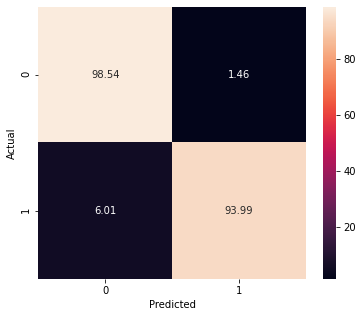

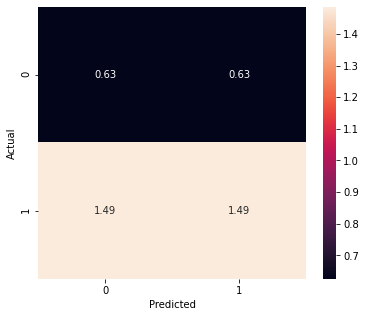

Average accuracy:  96.37219135384197
Std dev accuracy:  0.8209728927615338


In [ ]:
import time
# for _ in range(5):
# cm, cm_std = kf_validation(X_std, y, trained_cnn_model, verbose=True)
cm, cm_std, acc_mean, acc_std = kf_validation(feature_array, label_array, bt, rounds=5, verbose=True)

print('Average accuracy: ', acc_mean)
print('Std dev accuracy: ', acc_std)
# end  = time.time()
# print('#########################################################')
# print("time: ",end-begin)
# print('#########################################################')

In [ ]:
mask_sigs = label_array == 0
seq_sigs = feature_array[mask_sigs] 
print(len(seq_sigs), seq_sigs.shape)

mask_arte = label_array == 1
seq_arte = feature_array[mask_arte] 
print(len(seq_arte), seq_arte.shape)

1232 (1232, 2)
1122 (1122, 2)


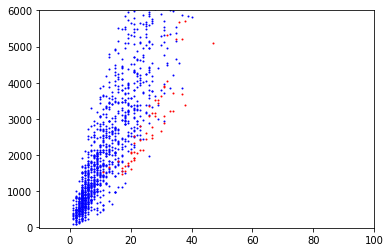

In [ ]:
from matplotlib import pyplot as plt

plt.figure()
plt.scatter(seq_sigs[:,0], seq_sigs[:,1], 1, c='b')
plt.scatter(seq_arte[:,0], seq_arte[:,1], 1, c='r')
axes = plt.gca()
axes.set_xlim([-10,100])
axes.set_ylim([-10,6*10**3])
plt.show()

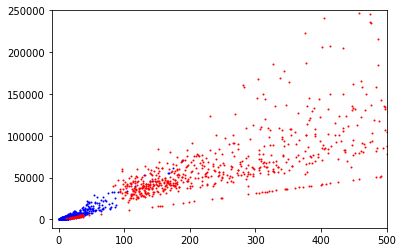

In [ ]:
from matplotlib import pyplot as plt

plt.figure()
plt.scatter(seq_sigs[:,0], seq_sigs[:,1], 1, c='b')
plt.scatter(seq_arte[:,0], seq_arte[:,1], 1, c='r')
axes = plt.gca()
axes.set_xlim([-10,500])
axes.set_ylim([-10**4,25*10**4])
plt.show()

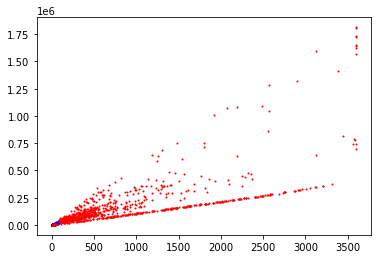

In [ ]:
from matplotlib import pyplot as plt

plt.figure()
plt.scatter(seq_sigs[:,0], seq_sigs[:,1], 1, c='b')
plt.scatter(seq_arte[:,0], seq_arte[:,1], 1, c='r')
axes = plt.gca()
# axes.set_xlim([-10,100])
# axes.set_ylim([-10,6*10**3])
plt.show()

In [ ]:
print(np.sum(seq_sigs[:,0] < 100),np.sum(seq_arte[:,0] < 100))

1224 71


In [ ]:
len(list(seq_sigs[:,0]))

1232

In [ ]:
len(list(seq_sigs[:,1]))

1232

In [ ]:
! wget -O ./credo.zip https://user.credo.science/user-interface/download/images/download.php?name=1.zip
! rm -rf ./credo-data
! unzip ./credo.zip -d ./credo-data

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
 extracting: ./credo-data/20389028.png  
 extracting: ./credo-data/20263139.png  
 extracting: ./credo-data/20269679.png  
 extracting: ./credo-data/20309399.png  
 extracting: ./credo-data/20270019.png  
 extracting: ./credo-data/20391311.png  
 extracting: ./credo-data/20347667.png  
 extracting: ./credo-data/20310186.png  
 extracting: ./credo-data/20252792.png  
 extracting: ./credo-data/20369887.png  
 extracting: ./credo-data/20383196.png  
 extracting: ./credo-data/20384462.png  
 extracting: ./credo-data/20384334.png  
 extracting: ./credo-data/20338427.png  
 extracting: ./credo-data/20384154.png  
 extracting: ./credo-data/20370418.png  
 extracting: ./credo-data/20255970.png  
 extracting: ./credo-data/20377874.png  
 extracting: ./credo-data/20372438.png  
 extracting: ./credo-data/20309283.png  
 extracting: ./credo-data/20347263.png  
 extracting: ./credo-data/20375390.png  
 extracting: ./credo-data/2024612

In [ ]:
import cv2
import glob

credo = []

for fn in glob.glob("credo-data/*.png"):
  img = cv2.imread(fn)

  # img = img.astype('int32')

  # blackwhite=img[:,:,0]+img[:,:,1]+img[:,:,2]

  # threshold = blackwhite.mean() + blackwhite.std() * 5
  # threshold = threshold if threshold < 100 else 100  

  # mask = np.where(blackwhite > threshold, 1, 0)
  # blackwhite = blackwhite * mask

  # credo.append(blackwhite)
  credo.append(img)

print(len(credo))

40000


In [ ]:
# verified_data = []
# for item in credo:
#   verified_data.append(item.reshape((60,60,1)).copy())

# verified_data = np.array(verified_data)

# results = np.argmax(trained_cnn_model.predict(verified_data), axis=1)
# print(np.sum(results==0), np.sum(results==1))

import numpy as np

n_sig = 0
n_art = 0
for i in range(4):

  size = 10000
  verified_data, _ = preprocessData(data=(credo[size*i:size*(i+1)], np.ones(size)))

  results = bt.predict(verified_data)
  print(np.sum(results==0), np.sum(results==1))

  n_sig += np.sum(results==0)
  n_art += np.sum(results==1)

print(n_sig, n_art)

(10000, 2)
(10000,)
9265 735
(10000, 2)
(10000,)
9305 695
(10000, 2)
(10000,)
9244 756
(10000, 2)
(10000,)
9272 728
37086 2914


In [ ]:
size = 10000
i = 3
signals = np.array(credo[size*i:size*(i+1)])[results==0]
artefacts = np.array(credo[size*i:size*(i+1)])[results==1]

print(len(signals), len(artefacts))

9272 728


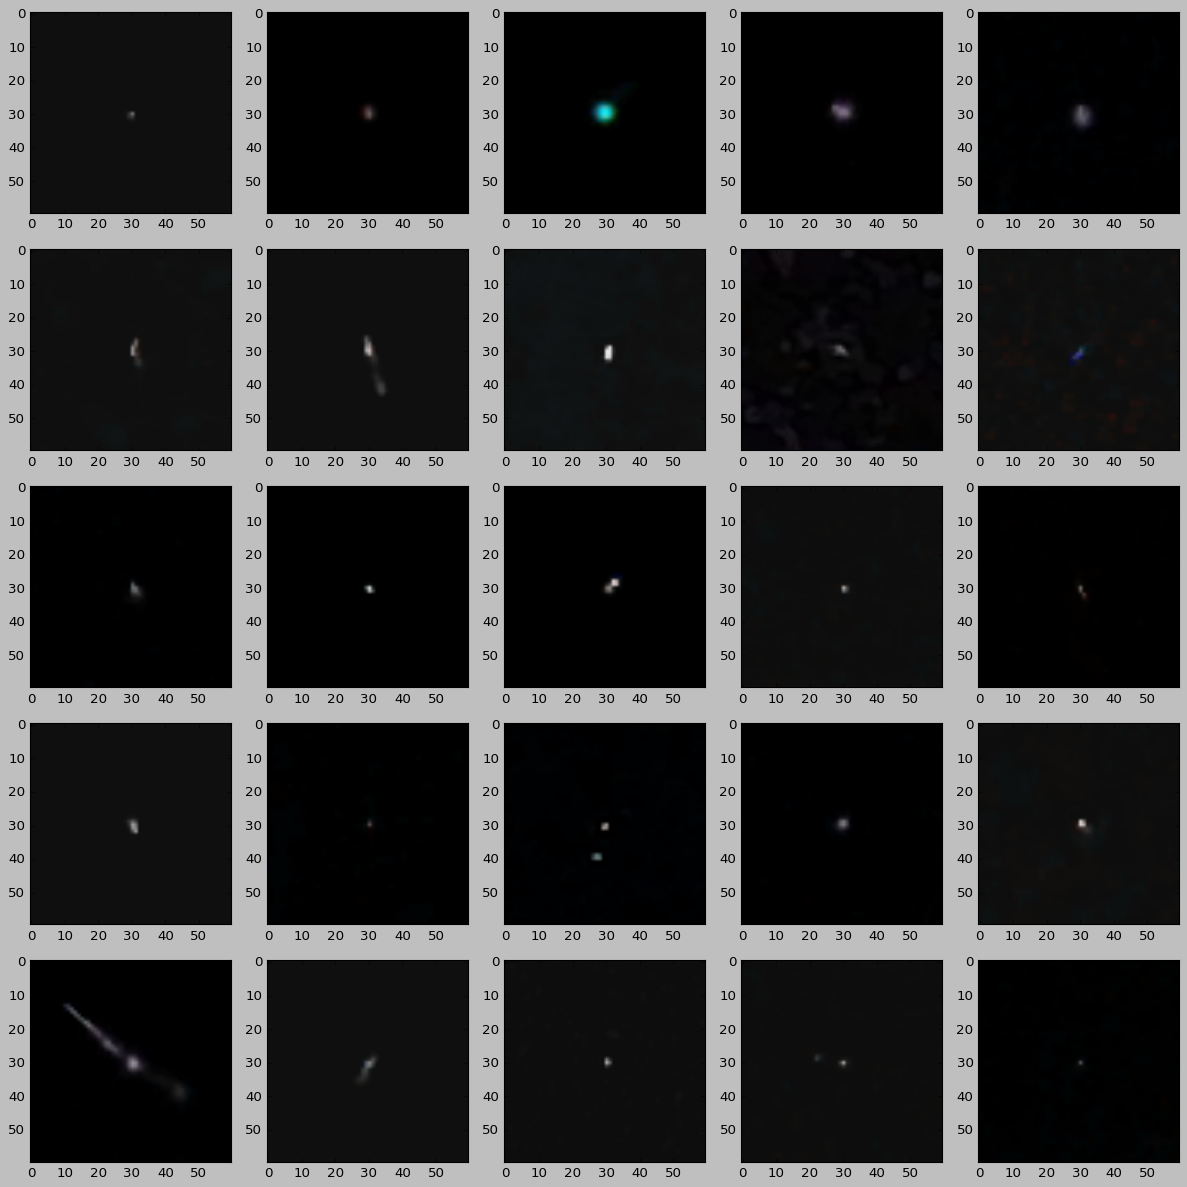

In [ ]:
import matplotlib.pyplot as plt

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

rows = cols = 5

plots = signals

# plt.figure(figsize=(4*rows,4*cols))
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(3*rows,3*cols))
idx = 0
for row in ax:
    for col in row:
        col.imshow(plots[idx], cmap='gray')
        # col.set_title(str(idx))
        idx += 1

fig.tight_layout()
plt.savefig('signals-credo.png', dpi=300)
plt.show()

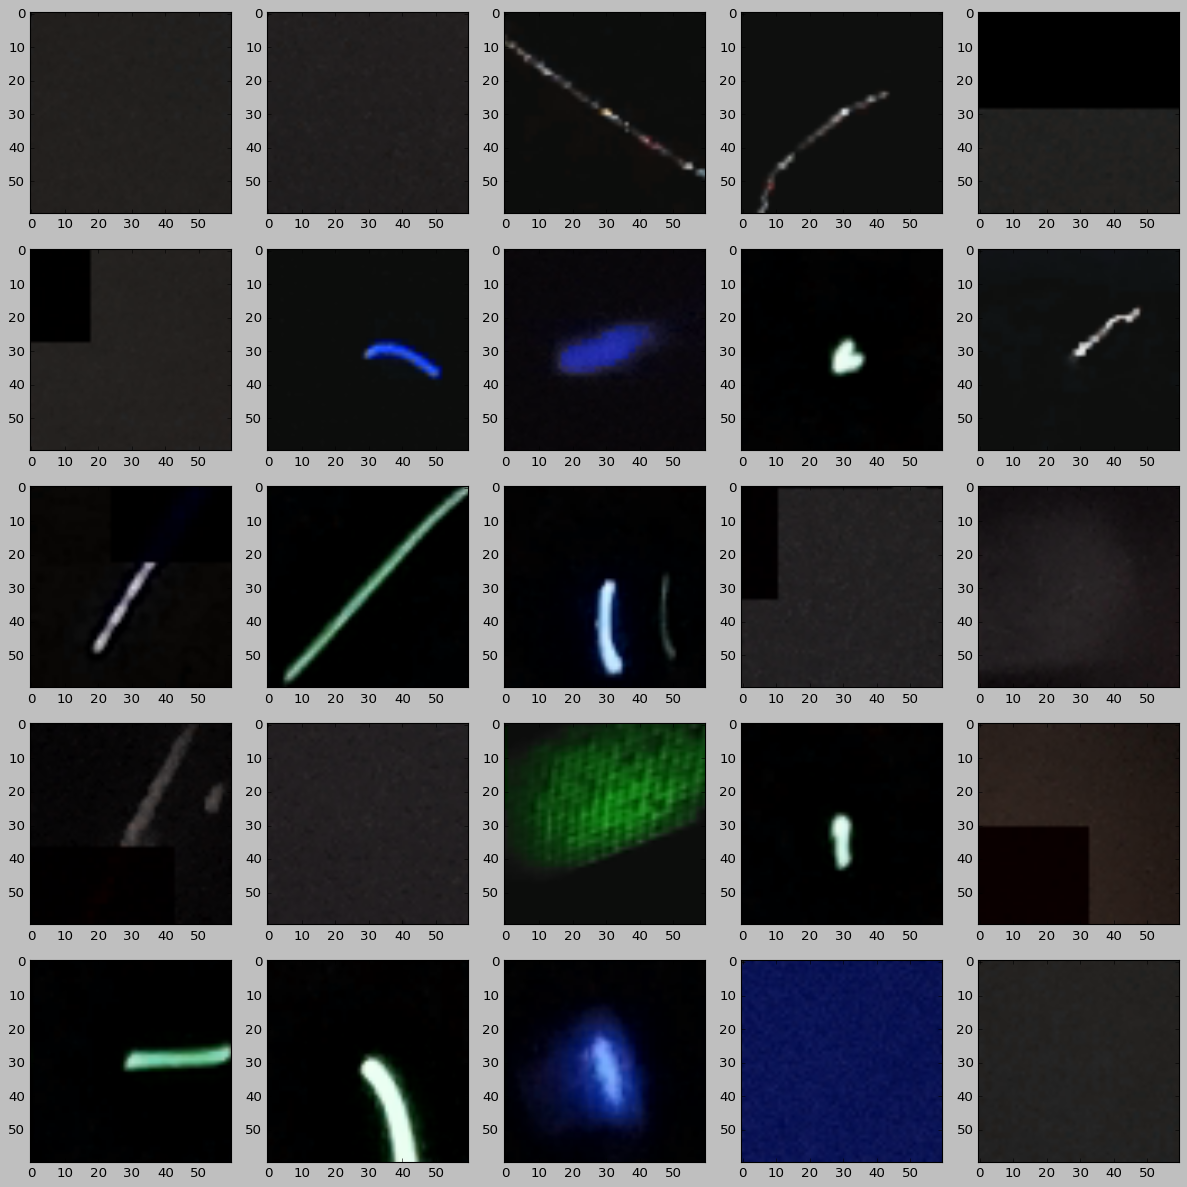

In [ ]:
import matplotlib.pyplot as plt

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

rows = cols = 5

plots = artefacts

# plt.figure(figsize=(4*rows,4*cols))
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(3*rows,3*cols))
idx = 0
for row in ax:
    for col in row:
        col.imshow(plots[idx], cmap='gray')
        # col.set_title(str(idx))
        idx += 1

fig.tight_layout()
plt.savefig('artefacts-credo.png', dpi=300)
plt.show()
